# Duffing — Chaos analysis (Lyapunov and perturbations)
This notebook demonstrates how to estimate a largest Lyapunov exponent, run perturbation tests, and interpret results.

In [1]:
# Notebook-friendly imports: ensure project root is on sys.path so local `duffing` package imports work
import sys, os
# compute project root (one level up from notebooks/)
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duffing.features import classify_by_lyapunov, estimate_lyapunov_benettin
from duffing.visualize import compute_perturbed_delta
print('numpy', np.__version__)
print('pandas', pd.__version__)

numpy 2.3.3
pandas 2.3.3


In [2]:
# Load a demo CSV (created by notebook 01)
df = pd.read_csv('../demo_small.csv') if False else pd.read_csv('demo_small.csv')
if 'base_id' not in df.columns:
    df['base_id'] = df.groupby(['delta','alpha','beta','omega']).ngroup()
row = df.iloc[5]
params = {k: float(row[k]) for k in ['delta','alpha','beta','omega','gamma']}
print('params:', params)

params: {'delta': 0.2201890828243247, 'alpha': 0.1649074221897368, 'beta': 0.6260932876862045, 'omega': 0.4891736157952284, 'gamma': 1.4578955785025856}


Loaded 'demo_small.csv' with 238 rows
Selected periodic params: {'delta': 0.1584282711630744, 'alpha': 1.8018547853037408, 'beta': 0.3739032641673041, 'omega': 1.9075690048470388, 'gamma': 0.5365640328146796}
Selected chaotic params: {'delta': 0.2276057550627152, 'alpha': -0.8783649680558403, 'beta': 1.021862851420107, 'omega': 1.9653269596422296, 'gamma': 1.4463200711293014}
Periodic classification (quick): {'lyap': -0.0783980748471997, 'label': 'periodic'}
Chaotic classification (quick): {'lyap': 0.2056276722519722, 'label': 'chaotic'}


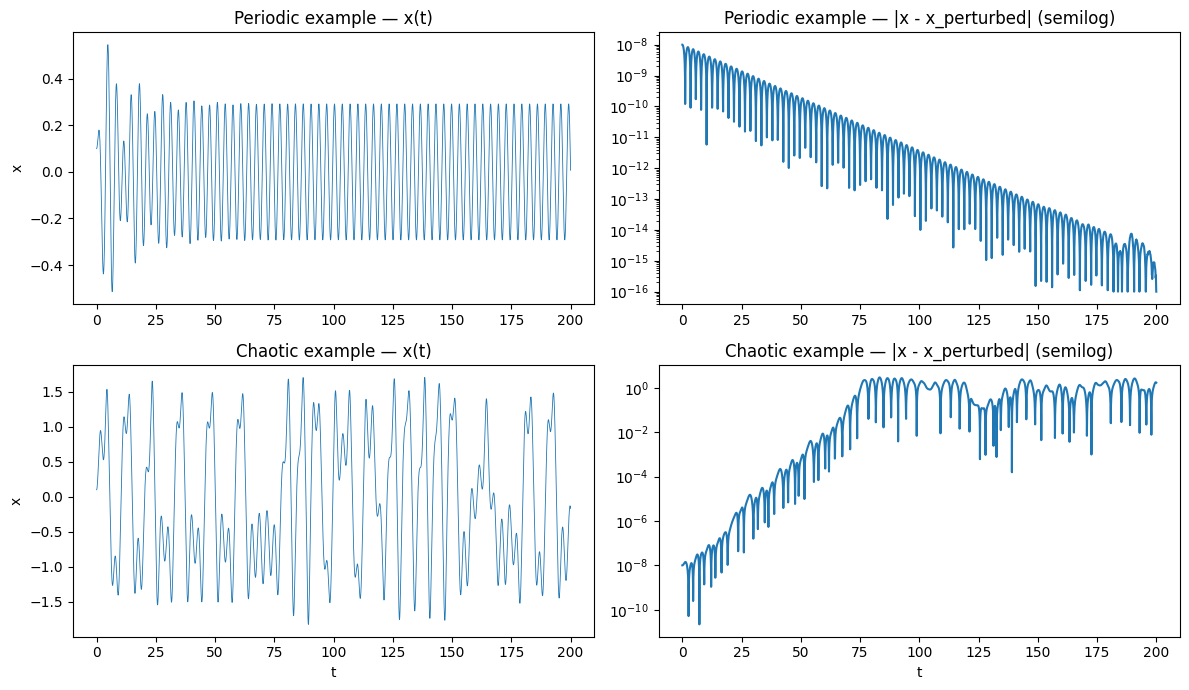

In [3]:
# Select first periodic and first chaotic examples from a demo CSV and plot them
# NOTE: this cell now requires that the input CSV include a precomputed 'lyapunov' column.
# The logic is simple: pick the first row with lyapunov < 0 as periodic and the first with lyapunov > 0 as chaotic.

import numpy as np
import matplotlib.pyplot as plt
from duffing.solver import solve_duffing

# helper to build params dict for functions in this notebook
def row_to_params(row):
    return {k: float(row[k]) for k in ['delta', 'alpha', 'beta', 'omega', 'gamma']}

# load demo_small.csv (preferred) or fall back to demo.csv
import os
csv_candidates = ['demo_small.csv', 'demo.csv']
for f in csv_candidates:
    if os.path.exists(f):
        df = pd.read_csv(f)
        print(f"Loaded '{f}' with {len(df)} rows")
        break
else:
    raise FileNotFoundError('Could not find demo_small.csv or demo.csv in the notebook folder')

# REQUIRE: lyapunov column must be present
if 'lyapunov' not in df.columns:
    raise RuntimeError("This notebook cell requires a 'lyapunov' column in the CSV. Re-run the generator with --compute-lyapunov or add LLEs to the CSV.")

# ensure base_id exists
if 'base_id' not in df.columns:
    df['base_id'] = df.groupby(['delta','alpha','beta','omega']).ngroup()

# select first periodic (lyap < 0) and first chaotic (lyap > 0)
neg = df[df['lyapunov'] < 0]
pos = df[df['lyapunov'] > 0]
if len(neg) == 0 or len(pos) == 0:
    raise RuntimeError('CSV must contain at least one negative and one positive lyapunov value to select periodic and chaotic examples.')

p_row = neg.iloc[0]
c_row = pos.iloc[0]

# Build parameter dicts
p_params = row_to_params(p_row)
c_params = row_to_params(c_row)

# Prepare (optional) detailed Lyapunov re-checks for display
p_res = {'lyap': float(p_row['lyapunov']), 'label': 'periodic' if p_row['lyapunov'] < 0 else 'chaotic'}
c_res = {'lyap': float(c_row['lyapunov']), 'label': 'periodic' if c_row['lyapunov'] < 0 else 'chaotic'}

print('Selected periodic params:', p_params)
print('Selected chaotic params:', c_params)
print('Periodic classification (quick):', p_res)
print('Chaotic classification (quick):', c_res)

# Simulate time series and perturbation growth for both examples
t_span = (0.0, 200.0)
# use a reasonably fine eval grid for plotting
t_eval = np.linspace(t_span[0], t_span[1], 5000)
sol_p = solve_duffing(t_span, (0.1, 0.0), p_params, t_eval=t_eval)
sol_c = solve_duffing(t_span, (0.1, 0.0), c_params, t_eval=t_eval)

# compute perturbed delta (Benettin-style difference) for visualization
# compute_perturbed_delta returns (t, delta)
t_p, delta_p = compute_perturbed_delta(p_params, t_span=t_span, y0=(0.1, 0.0), eps=1e-8)
t_c, delta_c = compute_perturbed_delta(c_params, t_span=t_span, y0=(0.1, 0.0), eps=1e-8)

# 2x2 plot: rows = periodic / chaotic, cols = time series / perturbation growth
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].plot(sol_p.t, sol_p.y[0], lw=0.6)
axs[0, 0].set_title('Periodic example — x(t)')
axs[0, 0].set_ylabel('x')

axs[0, 1].semilogy(t_p, np.clip(delta_p, 1e-16, None))
axs[0, 1].set_title('Periodic example — |x - x_perturbed| (semilog)')

axs[1, 0].plot(sol_c.t, sol_c.y[0], lw=0.6)
axs[1, 0].set_title('Chaotic example — x(t)')
axs[1, 0].set_xlabel('t')
axs[1, 0].set_ylabel('x')

axs[1, 1].semilogy(t_c, np.clip(delta_c, 1e-16, None))
axs[1, 1].set_title('Chaotic example — |x - x_perturbed| (semilog)')
axs[1, 1].set_xlabel('t')

plt.tight_layout()
plt.show()

In [9]:
# Classify via Lyapunov estimator (this can be slow)
res = classify_by_lyapunov(params, transient_cycles=30, measure_cycles=120, eps=1e-8, dt_cycles=1)
print(res)

{'lyap': -0.1403655193329439, 'label': 'periodic'}


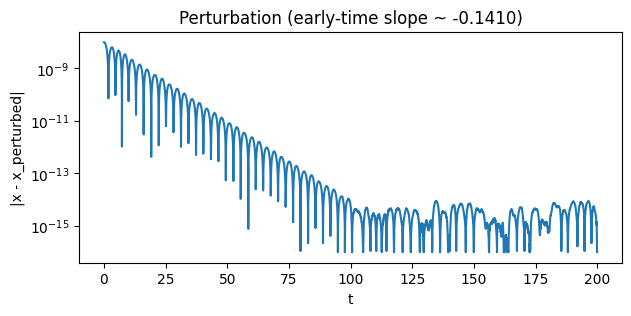

In [10]:
# Perturbation test and semilog plot (visual)
t, delta = compute_perturbed_delta(params, t_span=(0,200), y0=(0.1,0.0), eps=1e-8)
plt.figure(figsize=(7,3))
plt.semilogy(t, np.clip(delta, 1e-16, None))
plt.xlabel('t'); plt.ylabel('|x - x_perturbed|')
# Fit early-time slope for approximate lyapunov number
mask = (t>0) & (t<50)
if np.any(mask):
    coeffs = np.polyfit(t[mask], np.log(np.clip(delta[mask],1e-16,None)), 1)
    lyap_est = coeffs[0]
    plt.title(f'Perturbation (early-time slope ~ {lyap_est:.4f})')
else:
    plt.title('Perturbation (no early window)')
plt.show()

## Notes:
- `classify_by_lyapunov` uses a Benettin-style estimator and can be slow for long measure_cycles.
- Tune `eps`, `transient_cycles`, and `measure_cycles` to improve stability of the estimate.
- Use the perturbation semilog plot to visually assess exponential growth/decay before trusting numeric LLE.

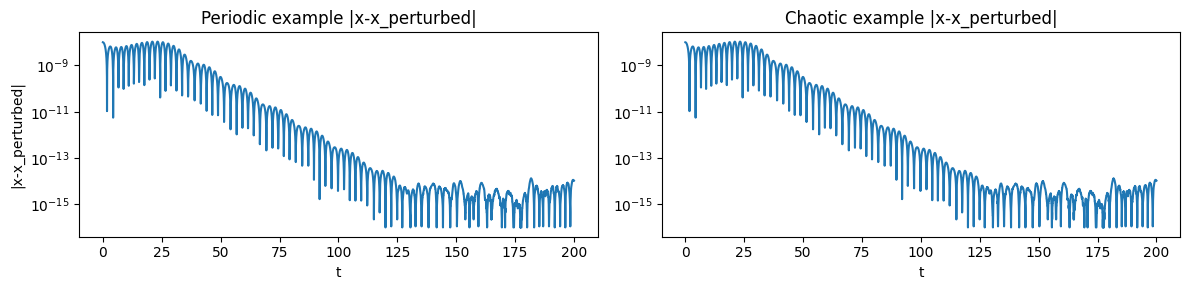

In [15]:
# Compare perturbation growth for periodic vs chaotic example side-by-side
# NOTE: compute_perturbed_delta and the params (p_params, c_params) should be defined in earlier cells.
# If not, define or re-run previous cells that compute/select p_params and c_params.

# Run the perturbation simulations (these can take a few seconds)
t_p, delta_p = compute_perturbed_delta(p_params, t_span=(0,200), y0=(0.1,0.0), eps=1e-8)
t_c, delta_c = compute_perturbed_delta(c_params, t_span=(0,200), y0=(0.1,0.0), eps=1e-8)

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(12,3))
axs[0].semilogy(t_p, np.clip(delta_p, 1e-16, None))
axs[0].set_title('Periodic example |x-x_perturbed|')
axs[0].set_xlabel('t'); axs[0].set_ylabel('|x-x_perturbed|')
axs[1].semilogy(t_c, np.clip(delta_c, 1e-16, None))
axs[1].set_title('Chaotic example |x-x_perturbed|')
axs[1].set_xlabel('t')
plt.tight_layout()
plt.show()